# Library 

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!mv VnCoreNLP-1.1.1.jar vncorenlp/

!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/


!mkdir -p vncorenlp/models/postagger
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/postagger/vi-tagger 
!mv vi-tagger vncorenlp/models/postagger/


!mkdir -p vncorenlp/models/ner
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/ner/vi-500brownclusters.xz
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/ner/vi-ner.xz 
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/ner/vi-pretrainedembeddings.xz
!mv vi-500brownclusters.xz vncorenlp/models/ner/
!mv vi-ner.xz vncorenlp/models/ner/
!mv vi-pretrainedembeddings.xz vncorenlp/models/ner/

--2023-03-29 06:32:48--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.09s   

2023-03-29 06:32:48 (287 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2023-03-29 06:32:49--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

# Hyper parameters

In [ ]:
max_len = 100
use_tokenizer = False
MODEL = 'xlm-roberta-base'

# Read data

In [ ]:
train_dataset = 'drive/MyDrive/CODE/ViTHSD/dataset/train.xlsx'
dev_dataset = 'drive/MyDrive/CODE/ViTHSD/dataset/dev.xlsx'
test_dataset = 'drive/MyDrive/CODE/ViTHSD/dataset/test.xlsx'

In [ ]:
import pandas as pd

train = pd.read_csv(train_dataset)
dev = pd.read_csv(dev_dataset)
test = pd.read_csv(test_dataset)

In [ ]:
len(train)

7000

In [ ]:
len(dev)

1201

In [ ]:
len(test)

1800

# EVAL metrics

In [ ]:
def precision(pred, y):
    sum = 0
    for i in range(0, len(pred)):
        if y[i] == pred[i] and pred[i] != 0:
            sum = sum + 1 

    pred = [i for i in pred if i != 0]

    return sum / len(pred) if len(pred) > 0 else 0

def recall(pred, y):
    sum = 0
    for i in range(0, len(pred)):
        if y[i] == pred[i] and pred[i] != 0:
            sum = sum + 1

    y = [i for i in y if i != 0]

    return sum / len(y) if len(y) > 0 else 0

def f1(pred, y):
    p = precision(pred, y)
    r = recall(pred, y)
    return 2*p*r / (p+r) if (p+r) != 0 else 0

def precision_score(preds, y):
    result = 0
    for i in range(0, len(preds)):
        result += precision(preds[i], y[i])
    return result / len(preds)

def recall_score(preds, y):
    result = 0
    for i in range(0, len(preds)):
        result += recall(preds[i], y[i])
    return result / len(preds)   

def f1_score(preds, y):
    return 2*precision_score(preds, y)*recall_score(preds, y) / (precision_score(preds, y)+recall_score(preds, y))

In [ ]:
a = [2, 1, 0, 2, 1]
b = [2, 2, 0, 2, 1]

f1(a, b)

0.75

# Feature extraction

In [ ]:
from vncorenlp import VnCoreNLP
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg") 

def tokennize_vn(text):
    sentences = vncorenlp.tokenize(text)
    s = ''
    for t in sentences:
        s = s + ' '.join(t) + ' '
    return s

In [ ]:
from keras.utils import to_categorical
import numpy as np

def make_data(data):
    content = [str(d) for d in data['content']]
    if use_tokenizer:
        content = [tokennize_vn(str(d)) for d in data['content']]
    # else:
    #     content = data['content'].values
    label = data.iloc[:,2:].values
    label_to_categorical = []
    for d in label:
        lb = []
        for i in d:
            t = np.zeros(4, dtype=int)
            t[i] = 1
            lb.append(t.tolist())
        label_to_categorical.append(lb)

    return content, label, label_to_categorical

In [ ]:
train_text, train_gt,  train_label = make_data(train)
dev_text, dev_gt, dev_label = make_data(dev)
test_text, test_gt, test_label = make_data(test)

In [ ]:
# from keras.utils import pad_sequences
# from keras.utils import to_categorical
# from keras.preprocessing.text import Tokenizer

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train_text)
# vocab_size = len(tokenizer.word_index) + 1

# def encoding(X, y):
#     # if not use_tokenizer:
#     #     X = X.astype(str)
#     X = tokenizer.texts_to_sequences(X)
#     X = pad_sequences(X, maxlen=max_len, padding='post')
#     y = np.asarray([np.asarray(row, dtype=float) for row in y], dtype=int)
#     return (X,y)

In [ ]:
from transformers import AutoTokenizer
from keras.utils import pad_sequences
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(MODEL)

def encoding(X, y):
    X = [str(x) for x in X]
    # X = pad_sequences(X, maxlen=max_len, padding='post')
    X = np.array(tokenizer(X, max_length=max_len, padding='max_length', truncation=True)['input_ids'])
    y = np.asarray([np.asarray(row, dtype=float) for row in y], dtype=int)
    return (X,y)

In [ ]:
# import pickle

# # saving
# with open('drive/MyDrive/CODE/ViTHSD/model/tokenizer2.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
train_features = encoding(train_text, train_label)
dev_features = encoding(dev_text, dev_label)
test_features = encoding(test_text, test_label)

# Model 

## Build model

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained(MODEL)
embedding_matrix = model.embeddings.word_embeddings.weight.detach().numpy()
# dim = model.embeddings.word_embeddings.embedding_dim
# vocab = model.embeddings.word_embeddings.num_embeddings
dim = embedding_matrix.shape[1]
vocab = embedding_matrix.shape[0]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Bi-GRU-LSTM-CNN

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, Model

from keras.layers import Dense, Concatenate, Bidirectional, GRU, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout1D, Dropout, concatenate
from keras.layers import Flatten, LSTM, Input, Reshape
from tensorflow.keras.layers import Embedding

units = 112
filter_size = 3

input = Input(shape = (max_len,))
emb = Embedding(vocab, dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input)
x1 = SpatialDropout1D(0.2)(emb)

x = Bidirectional(GRU(units, return_sequences = True))(x1)
x = Conv1D(filter_size, kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)
    
y = Bidirectional(LSTM(units, return_sequences = True))(x1)
y = Conv1D(filter_size, kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(y)
    
avg_pool1 = GlobalAveragePooling1D()(x)
max_pool1 = GlobalMaxPooling1D()(x)
    
avg_pool2 = GlobalAveragePooling1D()(y)
max_pool2 = GlobalMaxPooling1D()(y)
    
    
conc = Concatenate(axis=-1)([avg_pool1, max_pool1, avg_pool2, max_pool2])

output = Concatenate(axis=-1)([
        Dense(4, activation = 'softmax', name="target1")(conc),
        Dense(4, activation = 'softmax', name="target2")(conc),
        Dense(4, activation = 'softmax', name="target3")(conc),
        Dense(4, activation = 'softmax', name="target4")(conc),
        Dense(4, activation = 'softmax', name="target5")(conc)
    ])

model = Model(input, output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics="binary_accuracy")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 768)     192001536   ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 100, 768)    0           ['embedding_1[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 100, 224)    592704      ['spatial_dropout1d_1[0][0]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

history = model.fit(train_features[0].astype(np.float32), train_features[1].reshape(-1, 20), 
                    validation_data=(dev_features[0].astype(np.float32), dev_features[1].reshape(-1, 20)), 
                    batch_size=64, epochs=20, verbose=True,
                    callbacks=[early_stopping]
                )

Epoch 1/20
110/110 [==============================] - 36s 235ms/step - loss: 0.2481 - binary_accuracy: 0.8969 - val_loss: 0.2292 - val_binary_accuracy: 0.9022
Epoch 2/20
110/110 [==============================] - 23s 203ms/step - loss: 0.2062 - binary_accuracy: 0.9120 - val_loss: 0.2066 - val_binary_accuracy: 0.9093
Epoch 3/20
110/110 [==============================] - 16s 143ms/step - loss: 0.1788 - binary_accuracy: 0.9237 - val_loss: 0.2153 - val_binary_accuracy: 0.9062
Epoch 4/20
110/110 [==============================] - 15s 134ms/step - loss: 0.1544 - binary_accuracy: 0.9350 - val_loss: 0.2235 - val_binary_accuracy: 0.9034
Epoch 5/20
110/110 [==============================] - 12s 108ms/step - loss: 0.1258 - binary_accuracy: 0.9484 - val_loss: 0.2368 - val_binary_accuracy: 0.8991
Epoch 5: early stopping


In [ ]:
y_pred = model.predict(test_features[0])

57/57 [==============================] - 2s 13ms/step


## Evaluation

In [ ]:
import numpy as np

pred = np.argmax(y_pred.reshape(-1, 5, 4), axis=-1)

In [ ]:
print("Aspect + Polarity\n")
print("F1 = {}".format(f1_score(pred, test_gt)))
print("Precision = {}".format(precision_score(pred, test_gt)))
print("Recall = {}".format(recall_score(pred, test_gt)))

Aspect + Polarity

F1 = 0.4525004261702635
Precision = 0.4447222222222222
Recall = 0.46055555555555555


In [ ]:
model.save("drive/MyDrive/CODE/ViTHSD/model/{}.h5".format(MODEL))

In [ ]:
# Aspect only 

new_pred = []
new_y = []

for k in pred:
    t = []
    for i in k:
        if i > 0:
            t.append(1)
        else:
            t.append(i)
    new_pred.append(t)

for k in test_gt:
    t = []
    for i in k:
        if i > 0:
            t.append(1)
        else:
            t.append(i)
    new_y.append(t)

In [ ]:
print("Aspect\n")
print("F1 = {}".format(f1_score(new_pred, new_y)))
print("Precision = {}".format(precision_score(new_pred, new_y)))
print("Recall = {}".format(recall_score(new_pred, new_y)))

Aspect

F1 = 0.6511837028084851
Precision = 0.6459259259259261
Recall = 0.6565277777777778


In [ ]:
from sklearn.metrics import classification_report
tg = 4
print(classification_report(pred[:,tg], test_gt[:,tg]))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1744
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.52      0.54      0.53        56

    accuracy                           0.95      1800
   macro avg       0.38      0.38      0.38      1800
weighted avg       0.97      0.95      0.96      1800



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Results

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

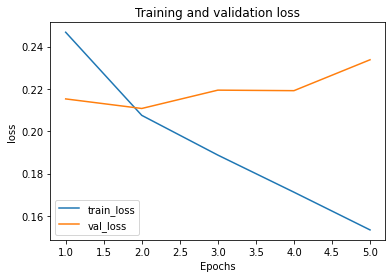

In [ ]:
plot_metric(history, 'loss')